## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##  Use the cleaned data for clustering

In [0]:
DATA_PATH = '/content/drive/My Drive/ALDA-Submission/Data/cleaned_data.csv'

## Import required libraries

In [0]:
import pandas as pd
import numpy as np
import nltk
from gensim import corpora
from functools import reduce
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent","hou", "ect"))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
df = pd.read_csv(DATA_PATH, index_col=0)
df.shape

(517401, 16)

## Vectorize text data

In [0]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 500,
    stop_words = stop
)
tfidf.fit(df['new_msg'].dropna())
text = tfidf.transform(df['new_msg'].dropna())

## Hyperparameter tuning for optimal number of clusters

In [0]:
max_k=32
data=text
iters = range(4, max_k+1, 2)

sse = []
for k in iters:
    sse_val = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_
    sse.append(sse_val)
    print('Fit {} clusters, sse {}'.format(k,sse_val))

Fit 4 clusters, sse 457289.4728152219
Fit 6 clusters, sse 451091.8430927665
Fit 8 clusters, sse 441894.4036899067
Fit 10 clusters, sse 438635.69004741835
Fit 12 clusters, sse 433910.8959583434
Fit 14 clusters, sse 429714.86307290033
Fit 16 clusters, sse 425585.8925256828
Fit 18 clusters, sse 422632.7485110797
Fit 20 clusters, sse 419289.7994297395
Fit 22 clusters, sse 413687.420001429
Fit 24 clusters, sse 423482.2245664004
Fit 26 clusters, sse 407720.7044529952
Fit 28 clusters, sse 405660.685704994
Fit 30 clusters, sse 414276.1453262809
Fit 32 clusters, sse 412857.2500821606


## Plot SSE vs number of clusters

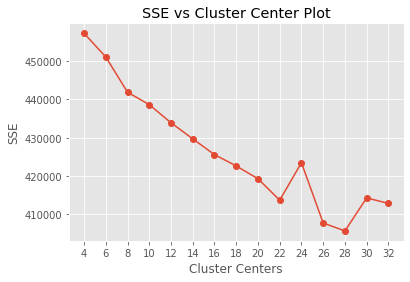

In [0]:
plt.style.use("ggplot")
f, ax = plt.subplots(1, 1)
ax.plot(iters, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('SSE')
ax.set_title('SSE vs Cluster Center Plot')
plt.savefig('/content/drive/My Drive/ALDA-Submission/Plots/Clustering-SSE.png')
plt.show()

## Model for optimal number of clusters

In [0]:
clusters = MiniBatchKMeans(n_clusters=28, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Print clusters with top terms

In [0]:
labels=tfidf.get_feature_names()
n_terms=10

new_df = pd.DataFrame(data.todense())
new_df['clusters'] = clusters
# new_df.to_csv('/content/drive/My Drive/ALDA-Submission/Data/clusters.csv')

In [0]:
clusters_mean = new_df.groupby(['clusters']).mean()

In [0]:
clusters_mean.head()

In [0]:
for i,r in clusters_mean.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


Cluster 0
number,mark,thank,jeff,day,today,list,new,need,please

Cluster 1
please,eb,standard,conference,date,scheduled,outage,call,pm,time

Cluster 2
total,current,distribution,asp,com,enron,please,attached,name,report

Cluster 3
mike,get,need,help,attached,question,send,call,please,thanks

Cluster 4
legal,houston,street,texas,eb,north,fax,smith,america,enron

Cluster 5
ferc,electricity,price,utility,said,market,energy,state,california,power

Cluster 6
com,communication,forwarded,et,enronxgate,pm,development,corp,na,enron

Cluster 7
price,need,volume,let,please,know,pm,enron,thanks,deal

Cluster 8
energy,williams,pm,com,please,committee,thanks,would,enron,bill

Cluster 9
forwarded,email,message,net,pm,aol,mail,www,enron,com

Cluster 10
richard,steven,com,jeff,corp,forwarded,na,pm,enron,ee

Cluster 11
thursday,wednesday,john,tuesday,monday,november,october,pm,original,message

Cluster 12
application,click,page,enron,com,asp,approval,resource,id,request

Cluster 13
go,time,good,know,we

## Drop cluster data points which are irrelevant

In [0]:
# new_df = pd.read_csv('/content/drive/My Drive/ALDA-Submission/Data/clusters.csv')
df01 = new_df.loc[new_df['clusters'] ==17]
ind_lst1 = list(df01.index)
df03 = new_df.loc[new_df['clusters'] ==13]
ind_lst3 = list(df03.index)
df02 = new_df.loc[new_df['clusters'] == 18]
ind_lst2 = list(df02.index)
new_ind_lst = ind_lst1 + ind_lst2 + ind_lst3
ind = list(set(new_ind_lst))
# for ind in ind_lst[100:110]:
#   print(df.loc[ind,'message_content'])

In [0]:
dfnew = df.drop(index = ind)

In [0]:
df.shape

(517401, 16)

In [0]:
# new_df = pd.read_csv('/content/drive/My Drive/ALDA-Submission/Data/red_data.csv')